In [1]:
!pip install -q clu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.


In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-10 10:15:58--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-05-10 10:15:58 (17.9 MB/s) - 'input.txt' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 256 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
expans = 2
n_head = 4
channel_size = n_embd // n_head
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(256, 64)
[[ 6  1 61 ... 53 50 42]
 [21  1 42 ... 44 47 43]
 [58 46 43 ... 43 56 43]
 ...
 [ 6  0 13 ... 46 53 59]
 [45 56 39 ...  1 41 53]
 [ 1 51 43 ... 57 46 53]]
targets:
(256, 64)
[[ 1 61 46 ... 50 42  0]
 [ 1 42 47 ... 47 43 56]
 [46 43  1 ... 56 43  1]
 ...
 [ 0 13 52 ... 53 59 45]
 [56 39 41 ... 41 53 51]
 [51 43 52 ... 46 53 61]]


In [13]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [14]:
xb.shape

(256, 64)

In [15]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(256, 128)

In [16]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (128,), 'kernel': (64, 128)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu --> 

In [17]:
class MambaBlock(nn.Module):
    
    def setup(self):          
        self.in_proj1 = nn.Dense(features=n_embd * expans)
        self.in_proj2 = nn.Dense(features=n_embd * expans)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=n_embd * expans,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, n_embd * expans, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1, n_embd * expans, block_size))
        
        self.out_proj = nn.Dense(n_embd)
        
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        
        embeds = x
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
        x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [18]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [19]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx    

In [20]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        seq_len = x.shape[1]

        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(seq_len))
        for _ in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
            x = x + nn.MultiHeadDotProductAttention(
              num_heads=self.num_heads,
              qkv_features=self.head_size,
              out_features=self.head_size * self.num_heads,
              dropout_rate=self.dropout_rate,
            )(
              x_norm,
              x_norm,
              mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
              deterministic=not training,
            )

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [21]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 1_282_176


((256, 64), (256, 64, 65))

In [22]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [23]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(64, dtype=int32)

In [24]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [25]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [26]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [27]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [28]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [29]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [30]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [31]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")    

  2%|▏         | 105/5000 [01:33<11:11,  7.29it/s]  

train epoch: 100, loss: 3.2220072746276855, accuracy: 18.22442626953125
test epoch: 100, loss: 2.9355552196502686, accuracy: 23.577880859375


  4%|▍         | 205/5000 [01:46<09:30,  8.41it/s]

train epoch: 200, loss: 2.489600419998169, accuracy: 33.69232177734375
test epoch: 200, loss: 2.152550458908081, accuracy: 42.803955078125


  6%|▌         | 305/5000 [02:00<09:26,  8.29it/s]

train epoch: 300, loss: 1.798126459121704, accuracy: 51.39898681640625
test epoch: 300, loss: 1.5753228664398193, accuracy: 57.818603515625


  8%|▊         | 405/5000 [02:14<09:23,  8.16it/s]

train epoch: 400, loss: 1.471495509147644, accuracy: 60.634273529052734
test epoch: 400, loss: 1.2577754259109497, accuracy: 66.314697265625


 10%|█         | 505/5000 [02:28<09:18,  8.06it/s]

train epoch: 500, loss: 0.9903113842010498, accuracy: 73.33843994140625
test epoch: 500, loss: 0.9259374141693115, accuracy: 74.517822265625


 12%|█▏        | 605/5000 [02:43<09:13,  7.93it/s]

train epoch: 600, loss: 0.72861647605896, accuracy: 80.44158935546875
test epoch: 600, loss: 0.7212088704109192, accuracy: 80.914306640625


 14%|█▍        | 705/5000 [02:58<09:11,  7.79it/s]

train epoch: 700, loss: 0.5389844179153442, accuracy: 85.45611572265625
test epoch: 700, loss: 0.5055801868438721, accuracy: 86.181640625


 16%|█▌        | 805/5000 [03:13<09:02,  7.73it/s]

train epoch: 800, loss: 0.492140531539917, accuracy: 86.9053955078125
test epoch: 800, loss: 0.5794918537139893, accuracy: 84.0087890625


 18%|█▊        | 905/5000 [03:27<08:38,  7.89it/s]

train epoch: 900, loss: 0.4702460765838623, accuracy: 87.34276580810547
test epoch: 900, loss: 0.5115674734115601, accuracy: 86.749267578125


 20%|██        | 1005/5000 [03:42<08:23,  7.94it/s]

train epoch: 1000, loss: 0.42768704891204834, accuracy: 88.73748779296875
test epoch: 1000, loss: 0.34855711460113525, accuracy: 90.484619140625


 22%|██▏       | 1105/5000 [03:56<08:10,  7.94it/s]

train epoch: 1100, loss: 0.339140385389328, accuracy: 91.09539031982422
test epoch: 1100, loss: 0.5587704181671143, accuracy: 84.228515625


 24%|██▍       | 1205/5000 [04:11<08:02,  7.87it/s]

train epoch: 1200, loss: 0.28687578439712524, accuracy: 92.28656005859375
test epoch: 1200, loss: 0.22525060176849365, accuracy: 94.0185546875


 26%|██▌       | 1305/5000 [04:26<07:51,  7.84it/s]

train epoch: 1300, loss: 0.18423433601856232, accuracy: 95.23956298828125
test epoch: 1300, loss: 0.1919093132019043, accuracy: 94.903564453125


 28%|██▊       | 1405/5000 [04:41<07:37,  7.85it/s]

train epoch: 1400, loss: 0.16306783258914948, accuracy: 95.840087890625
test epoch: 1400, loss: 0.26977887749671936, accuracy: 92.98095703125


 30%|███       | 1505/5000 [04:55<07:23,  7.88it/s]

train epoch: 1500, loss: 0.24309328198432922, accuracy: 93.80284881591797
test epoch: 1500, loss: 0.2404954582452774, accuracy: 93.20068359375


 32%|███▏      | 1605/5000 [05:10<07:09,  7.90it/s]

train epoch: 1600, loss: 0.24328023195266724, accuracy: 94.15704345703125
test epoch: 1600, loss: 0.3133232593536377, accuracy: 92.742919921875


 34%|███▍      | 1705/5000 [05:25<06:57,  7.88it/s]

train epoch: 1700, loss: 0.2828502953052521, accuracy: 93.40264892578125
test epoch: 1700, loss: 0.36686059832572937, accuracy: 91.4306640625


 36%|███▌      | 1805/5000 [05:39<06:46,  7.87it/s]

train epoch: 1800, loss: 0.24532189965248108, accuracy: 93.81603240966797
test epoch: 1800, loss: 0.2620540261268616, accuracy: 93.00537109375


 38%|███▊      | 1905/5000 [05:54<06:34,  7.85it/s]

train epoch: 1900, loss: 0.24250489473342896, accuracy: 93.76019287109375
test epoch: 1900, loss: 0.23828470706939697, accuracy: 93.45703125


 40%|████      | 2005/5000 [06:09<06:21,  7.86it/s]

train epoch: 2000, loss: 0.23410065472126007, accuracy: 94.28277587890625
test epoch: 2000, loss: 0.18999990820884705, accuracy: 95.3369140625


 42%|████▏     | 2105/5000 [06:23<06:08,  7.85it/s]

train epoch: 2100, loss: 0.34009024500846863, accuracy: 92.294189453125
test epoch: 2100, loss: 0.3703247308731079, accuracy: 91.058349609375


 44%|████▍     | 2205/5000 [06:38<05:55,  7.85it/s]

train epoch: 2200, loss: 0.30437761545181274, accuracy: 92.4560546875
test epoch: 2200, loss: 0.28954046964645386, accuracy: 92.559814453125


 46%|████▌     | 2305/5000 [06:53<05:42,  7.86it/s]

train epoch: 2300, loss: 0.35460788011550903, accuracy: 91.79913330078125
test epoch: 2300, loss: 0.6036379337310791, accuracy: 86.4013671875


 48%|████▊     | 2405/5000 [07:08<05:30,  7.86it/s]

train epoch: 2400, loss: 0.3541470170021057, accuracy: 91.30217742919922
test epoch: 2400, loss: 0.2881474196910858, accuracy: 92.71240234375


 50%|█████     | 2505/5000 [07:22<05:17,  7.85it/s]

train epoch: 2500, loss: 0.2550797462463379, accuracy: 93.41796875
test epoch: 2500, loss: 0.25476014614105225, accuracy: 93.45703125


 52%|█████▏    | 2605/5000 [07:37<05:05,  7.85it/s]

train epoch: 2600, loss: 0.26534968614578247, accuracy: 93.1785888671875
test epoch: 2600, loss: 0.3138192892074585, accuracy: 91.50390625


 54%|█████▍    | 2705/5000 [07:52<04:52,  7.84it/s]

train epoch: 2700, loss: 0.24042575061321259, accuracy: 93.73919677734375
test epoch: 2700, loss: 0.20697417855262756, accuracy: 94.451904296875


 56%|█████▌    | 2805/5000 [08:06<04:39,  7.84it/s]

train epoch: 2800, loss: 0.19638855755329132, accuracy: 94.8603515625
test epoch: 2800, loss: 0.1867353320121765, accuracy: 94.95849609375


 58%|█████▊    | 2905/5000 [08:21<04:26,  7.85it/s]

train epoch: 2900, loss: 0.19605250656604767, accuracy: 94.88774871826172
test epoch: 2900, loss: 0.17111241817474365, accuracy: 95.39794921875


 60%|██████    | 3005/5000 [08:36<04:14,  7.84it/s]

train epoch: 3000, loss: 0.1666150838136673, accuracy: 95.56231689453125
test epoch: 3000, loss: 0.17541614174842834, accuracy: 95.37353515625


 62%|██████▏   | 3105/5000 [08:51<04:01,  7.84it/s]

train epoch: 3100, loss: 0.15852096676826477, accuracy: 95.82244873046875
test epoch: 3100, loss: 0.34243592619895935, accuracy: 93.5546875


 64%|██████▍   | 3205/5000 [09:05<03:48,  7.85it/s]

train epoch: 3200, loss: 0.2537677586078644, accuracy: 93.814453125
test epoch: 3200, loss: 0.1703539341688156, accuracy: 95.5078125


 66%|██████▌   | 3305/5000 [09:20<03:36,  7.84it/s]

train epoch: 3300, loss: 0.14582686126232147, accuracy: 96.10283660888672
test epoch: 3300, loss: 0.17310643196105957, accuracy: 95.343017578125


 68%|██████▊   | 3405/5000 [09:35<03:22,  7.86it/s]

train epoch: 3400, loss: 0.14423759281635284, accuracy: 96.173828125
test epoch: 3400, loss: 0.13522373139858246, accuracy: 96.343994140625


 70%|███████   | 3505/5000 [09:50<03:10,  7.85it/s]

train epoch: 3500, loss: 0.17092561721801758, accuracy: 95.9117431640625
test epoch: 3500, loss: 0.21896900236606598, accuracy: 93.975830078125


 72%|███████▏  | 3605/5000 [10:04<02:57,  7.87it/s]

train epoch: 3600, loss: 0.208559051156044, accuracy: 95.05462646484375
test epoch: 3600, loss: 0.17116545140743256, accuracy: 95.49560546875


 74%|███████▍  | 3705/5000 [10:19<02:44,  7.86it/s]

train epoch: 3700, loss: 0.2564133405685425, accuracy: 93.8240966796875
test epoch: 3700, loss: 0.19146263599395752, accuracy: 94.915771484375


 76%|███████▌  | 3805/5000 [10:34<02:31,  7.86it/s]

train epoch: 3800, loss: 0.17190314829349518, accuracy: 95.703125
test epoch: 3800, loss: 0.15157942473888397, accuracy: 96.136474609375


 78%|███████▊  | 3905/5000 [10:48<02:19,  7.87it/s]

train epoch: 3900, loss: 0.16229908168315887, accuracy: 95.9859619140625
test epoch: 3900, loss: 0.2962825298309326, accuracy: 93.524169921875


 80%|████████  | 4005/5000 [11:03<02:06,  7.87it/s]

train epoch: 4000, loss: 0.2009628415107727, accuracy: 95.00048828125
test epoch: 4000, loss: 0.16659146547317505, accuracy: 95.635986328125


 82%|████████▏ | 4105/5000 [11:18<01:53,  7.85it/s]

train epoch: 4100, loss: 0.19107528030872345, accuracy: 95.17406463623047
test epoch: 4100, loss: 0.1638445258140564, accuracy: 95.672607421875


 84%|████████▍ | 4205/5000 [11:32<01:40,  7.88it/s]

train epoch: 4200, loss: 0.1595885306596756, accuracy: 95.88970184326172
test epoch: 4200, loss: 0.17328673601150513, accuracy: 95.416259765625


 86%|████████▌ | 4305/5000 [11:47<01:28,  7.84it/s]

train epoch: 4300, loss: 0.1660011261701584, accuracy: 95.78899383544922
test epoch: 4300, loss: 0.3109043836593628, accuracy: 92.022705078125


 88%|████████▊ | 4405/5000 [12:02<01:15,  7.87it/s]

train epoch: 4400, loss: 0.24554090201854706, accuracy: 93.7135009765625
test epoch: 4400, loss: 0.15566465258598328, accuracy: 95.83740234375


 90%|█████████ | 4505/5000 [12:17<01:03,  7.85it/s]

train epoch: 4500, loss: 0.20285417139530182, accuracy: 95.1839599609375
test epoch: 4500, loss: 0.22967255115509033, accuracy: 93.707275390625


 92%|█████████▏| 4605/5000 [12:31<00:50,  7.87it/s]

train epoch: 4600, loss: 0.15294016897678375, accuracy: 96.0853271484375
test epoch: 4600, loss: 0.1582251787185669, accuracy: 95.54443359375


 94%|█████████▍| 4705/5000 [12:46<00:37,  7.87it/s]

train epoch: 4700, loss: 0.12107659876346588, accuracy: 96.7808837890625
test epoch: 4700, loss: 0.11385025829076767, accuracy: 96.966552734375


 96%|█████████▌| 4805/5000 [13:01<00:24,  7.87it/s]

train epoch: 4800, loss: 0.15292136371135712, accuracy: 96.29119873046875
test epoch: 4800, loss: 0.16182509064674377, accuracy: 95.831298828125


 98%|█████████▊| 4905/5000 [13:15<00:12,  7.87it/s]

train epoch: 4900, loss: 0.16169622540473938, accuracy: 96.21623992919922
test epoch: 4900, loss: 0.20290759205818176, accuracy: 95.159912109375


100%|██████████| 5000/5000 [13:30<00:00,  6.17it/s]

train epoch: 5000, loss: 0.20251178741455078, accuracy: 94.9371337890625
test epoch: 5000, loss: 0.3938335180282593, accuracy: 91.497802734375


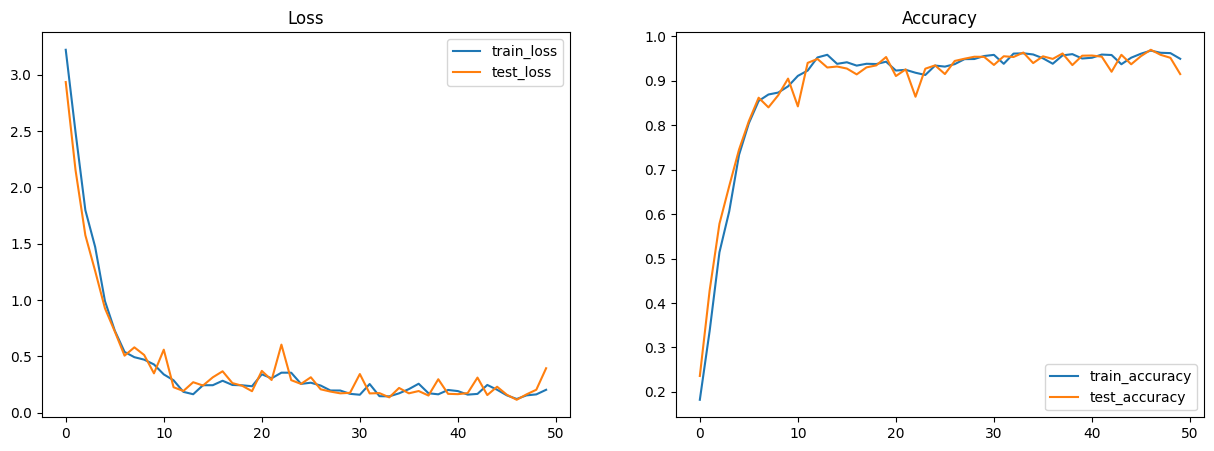

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [33]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.690998


In [34]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx    

In [45]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [50]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 19, 21, 31, 21, 33, 23, 10, 0, 27, 31, 21, 24, 14, 31, 23, 10, 0, 14, 53, 63, 1, 60, 53, 60, 43, 56, 43, 57, 2, 0, 27, 59, 50, 50, 0, 13, 58, 1, 21, 56, 43, 1, 39, 57, 1, 57, 39, 57, 51, 12, 0, 43, 44, 39, 50, 50, 1, 45, 53, 58, 50, 50, 47, 52, 43, 1, 63, 53, 56, 56, 42, 1, 21, 1, 51, 39, 40, 50, 53, 53, 1, 58, 46, 43, 1, 52, 53, 58, 41, 43, 39, 41, 59, 41, 46, 6, 56, 50, 50, 39, 57, 58, 53, 40, 47, 49, 1, 44, 43, 57, 6, 1, 44, 56, 53, 59, 50, 50, 7, 1, 40, 46, 52, 45, 1, 39, 59, 58, 1, 21, 43, 57, 1, 63, 53, 53, 51, 43, 1, 58, 46, 47, 52, 1, 39, 52, 42, 1, 39, 51, 43, 41, 49, 51, 39, 45, 43, 39, 60, 43, 50, 60, 43, 52, 45, 51, 43, 52, 1, 19, 53, 56, 58, 1, 46, 39, 42, 57, 1, 57, 47, 51, 43, 43, 42, 1, 40, 53, 59, 52, 45, 50, 50, 1, 46, 43, 53, 59, 56, 47, 52, 45, 40, 43, 1, 58, 53, 1, 51, 63, 1, 39, 58, 1, 42, 43, 1, 44, 53, 51, 39, 49, 43, 1, 58, 46, 43, 39, 56, 56, 43, 6, 1, 53, 59, 56, 57, 50, 50, 1, 58, 53, 50, 6, 0, 13, 45, 50, 39, 42, 1, 57, 53, 46, 59, 50, 1, 59, 47, 51, 4

In [49]:
print(decode(token_gen))

LGISIUK:
OSILBSK:
Boy voveres!
Oull
At Ire as sasm?
efall gotlline yorrd I mabloo the notceacuch,rllastobik fes, froull- bhng aut Ies yoome thin and ameckmageavelvengmen Gort hads simeed boungll heouringbe to my at de fomake thearre, oursll tol,
Aglad sohul uimes nof prer thers eredell at begpad barry.

BELM:
MH: sholle.

FOOCUCUED?
ISOIINGIHAI at of noteld, whou, he thameattes.

Gorerron?-
OMINLORK:
Hy yomo theavelrr wid, sogen.

ICA LARO: Ryy my thall nat wet shirood is pauve rio.

Pub se sr mes.

KRELKETCons,
Griio thes yo, x O timerly!
shearat car lort: whio gothslierfe pongn
Hoes, sorowathrtn anplfo prirhis weat suk-e wougeleres wit' pay'thpy yoid goukies; YO: whiteris!
h is Ry wnt nol yomernsth sog le yo to con we caw weamenotnoklls To thereerdplecfate idol.

OISEKORES:
Lor, Thel.
Bog, howedllcengy day. Vort

Aches bacalt heiom bomitods my fONn, thatio, as arealetarpfeluve haveds the eece ret bemast bet hall he couust eha?
 sors witindy mey deeuch Isumee moll is tewn afld?

BRIRS

In [65]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 2_289_089


In [ ]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

In [ ]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [ ]:
token_gen[:,-32:]

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next